In [1]:
### TO RUN
import os
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


2025-05-06 09:06:30.024799: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 09:06:30.029009: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 09:06:30.042965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746515190.067113   31092 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746515190.074197   31092 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746515190.091294   31092 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
np.random.seed(0)

Useful functions to select, read and play the dataset sounds are provided in ``classification/utils/audio_student.py``. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 2. Training and Evaluating models on audio signals [~1h30-2h] </font> <br>

In [3]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))
print(len(classnames))

{'chainsaw': [PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_000.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_001.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_010.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_011.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_020.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_021.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_030.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_031.wav'), Po

In [4]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In H1, it was not made explicit what we choose as input for the classification model, a.k.a. ``feature vector`` (it was shown in the illustration). <br>
The objective is, on the transmitter side, to compute a feature vector containing enough information about the audio signal we want to classify, but not too much in order to limit the data which has to be transmitted wirelessly. This is why in H1 we implemented the ``Hz2Mel`` conversion: a very simple compression of the frequency content. <br>
The feature vector we will use here simply consists in taking the first 20 columns of the melspectrogram, corresponding to ~1s, then reshaping it as a vector. This means each feature vector contains ``400`` coefficients, with 20 columns of 20 mels each.  <br>

Once the feature vector has been recovered on the receiver side, we can apply any computation on it to guess the right class this sound belongs to. Today, we will simply reuse the simple KNN and LDA classifiers and look at what we already get. 

<font size=3 color=#FF0000> Important :</font> <br>
The analyses that follow are given as food for thoughts. They are not given as step by step improvements of the classifier.

<font size=5 color=#009999> 2.1. Creation of the dataset </font> <br>

``Feature_vector_DS`` is a class defined in ``classification/utils/audio_student.py``. <br>
The functions ``__len__`` and ``__getitem__`` are implemented, meaning you can call :
- ``len(myds)`` to get the number of sounds in it.
- ``myds[classname,j]`` to get the melspectrogram of the ``j``-th sound from class ``classname``. <br>

Two other useful functions are provided:
- ``get_audiosignal`` returning the temporal audiosignal at the specified index.
- ``display`` playing the sound and showing the associated mel-spectrogram at the specified index.

<font size=3 color=#FF0000> Important :</font> <br>
Before being able to run the cells below, you will have to reuse your functions from H1 to fill the missing lines in ``audio_student.py`` at ``###TO COMPLETE`` locations.

In [5]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950 )

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

# idx = 10
# myds.display(["chainsaw", idx])


# idx = 1
# myds.display(["fireworks", idx])
# print(myds["fire", 0])

18

Running the cell above many times, you should notice it is always the beginning of the sound that is taken for creating the feature vector. ``shift_pct`` meaning *shift percentage* allows to roll the audio signal with a random factor upper bounded by this value. Change ``shift_pct`` to ``0.2`` and observe what happens.

In [6]:
# --- Paramètres ---
train_pct = 0.7
featveclen = len(myds["fire", 0])  # taille d’un vecteur de caractéristiques
nitems = len(myds)
naudio = dataset.naudio  # dict: nombre d’audios par classe
nclass = dataset.nclass  # nombre total de classes
data_aug_factor = 1
classnames = list(naudio.keys())  # assure que classnames est bien défini
naudio_sum = sum(naudio.values())  # total d’échantillons toutes classes confondues

# ID des classes (répétés selon le nombre d’audios par classe)
class_ids_aug = np.concatenate([
    np.repeat(classname, naudio[classname] * data_aug_factor) for classname in classnames
])

# --- Préparation des offsets cumulatifs pour les index globaux ---
offsets = {}
current_offset = 0
for cname in classnames:
    offsets[cname] = current_offset
    current_offset += naudio[cname]

# --- Allocation de la matrice X ---
X = np.zeros((data_aug_factor * naudio_sum, featveclen))

# --- Remplissage de X avec les vecteurs de caractéristiques ---
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio[classname]):
            featvec = myds[classname, idx]

            global_idx = s * naudio_sum + offsets[classname] + idx
            X[global_idx, :] = featvec

            # Debug
            if global_idx == 225:
                print("ici------------------------------------------------")
            print(f"Index: {global_idx}, Class Name: {classname}")

# --- Étiquettes ---
y = class_ids_aug.copy()
classnames = np.unique(y)

np.save(fm_dir + "feature_matrix_2D.npy", X)
np.save(fm_dir + "labels_2D.npy", y)

# --- Affichage de résumé ---
print("-" * 20)
for idx, elem in enumerate(X):
    mean_value = np.mean(elem)
    class_name = y[idx]
    print(f"Index: {idx}, Class Name: {class_name}, Mean Value: {mean_value}")
    
X = np.load(fm_dir + "feature_matrix_2D.npy")
y = np.load(fm_dir + "labels_2D.npy")

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")

Index: 0, Class Name: chainsaw
Index: 1, Class Name: chainsaw
Index: 2, Class Name: chainsaw
Index: 3, Class Name: chainsaw
Index: 4, Class Name: chainsaw
Index: 5, Class Name: chainsaw
Index: 6, Class Name: chainsaw
Index: 7, Class Name: chainsaw
Index: 8, Class Name: chainsaw
Index: 9, Class Name: chainsaw
Index: 10, Class Name: chainsaw
Index: 11, Class Name: chainsaw
Index: 12, Class Name: chainsaw
Index: 13, Class Name: chainsaw
Index: 14, Class Name: chainsaw
Index: 15, Class Name: chainsaw
Index: 16, Class Name: chainsaw
Index: 17, Class Name: chainsaw
Index: 18, Class Name: chainsaw
Index: 19, Class Name: chainsaw
Index: 20, Class Name: chainsaw
Index: 21, Class Name: chainsaw
Index: 22, Class Name: chainsaw
Index: 23, Class Name: chainsaw
Index: 24, Class Name: chainsaw
Index: 25, Class Name: chainsaw
Index: 26, Class Name: chainsaw
Index: 27, Class Name: chainsaw
Index: 28, Class Name: chainsaw
Index: 29, Class Name: chainsaw
Index: 30, Class Name: chainsaw
Index: 31, Class N

You might notice that ``feature_matrix_2D.npy`` has been saved in ``data/feature_matrices/`` and can now be loaded instead of recomputing it at every run.

<font size=5 color=#009999> 2.2. First audio classification, metrics and dataset splitting </font> <br>

For now we have only prepared the dataset, it remains to feed it to the classifiers. <br>

In [7]:
n = 14  # Number of principal components kept
model_pca = PCA(n_components=n, whiten=True)
# [4] Model training and selection.
K = 8
model_knn = KNeighborsClassifier(n_neighbors=K, weights="distance")

model_rf = RandomForestClassifier(n_estimators=100, 
                             max_depth=2,
                             min_impurity_decrease=0.01
                             ,min_samples_leaf=2,
                             min_samples_split=3,
                             random_state=0)
model_lda = LDA(
    solver="svd",
    shrinkage=None,
    priors=None,
    n_components=None,
    store_covariance=False,
    tol=0.0001,
    covariance_estimator=None,
) 



As for the toy example, we keep the ``accuracy`` and ``confusion matrix`` as performance metrics. <br>

Note that here we are not especially interested in a model selection hence we only split the dataset in training and testing parts but we don't split the training set in learning/validation parts. The models are trained on the entire training set.

<font size=5 color=#009999> 2.6. Augmenting the data </font> <br>

In order to make our classifier more robust to some common transformations of the audio signal such as ``time shift``, ``AWGN``, or a ``transfer function``, an idea consists in feeding the classifier with such transformations. A popular approach is to create new feature vectors based on transformed versions of the sounds from the original dataset, this is called ``data augmentation``. Data augmentation is also often used when there is few data to train a model. <br>

The functions to augment your data are written in ``utils/audio_student.py``, we already implemented ``time_shift``, ``echo`` and ``spectro_aug_timefreq_masking`` for you. Try to implement ``scaling``, ``add_noise``, ``filter``, ``add_bg`` and even more data augmentation techniques if you want, and check their working in the cell below. <br>

<u>Tip</u>: to avoid restarting the notebook kernel for each modification, you can temporarily insert the ``AudioUtil`` class in a new cell and make your tests until it is working as expected. 

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


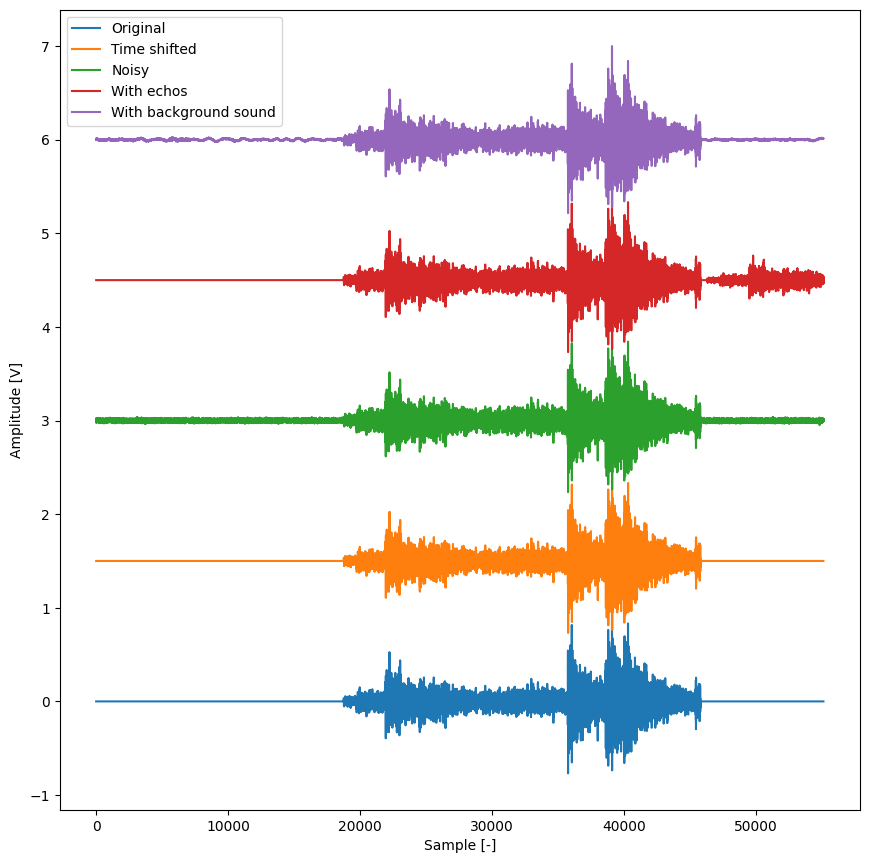

Plot saved as audio_augmentations.pdf


In [8]:
from matplotlib.backends.backend_pdf import PdfPages

### TO RUN
myds.data_aug = None  # Ensure

cls_index = ["fire", 2]

sound = dataset.__getitem__(cls_index)
name = dataset.__getname__(cls_index)
audio = AudioUtil.open(sound)
audio_tmp = AudioUtil.open(sound)
AudioUtil.play(audio)
audio2 = AudioUtil.resample(audio, 11025)
audio2 = AudioUtil.pad_trunc(audio2, 5000)

audio3 = AudioUtil.time_shift(audio2, 0.5)
audio4 = AudioUtil.scaling(audio2)
audio5 = (audio2[0] + np.random.normal(0, 0.01, len(audio2[0])), audio2[1])
audio6 = AudioUtil.echo(audio2)
audio7 = AudioUtil.add_background_noise(audio2, 20)

melspec = AudioUtil.melspectrogram(audio2, fs2=11025)
melspec2 = AudioUtil.spectro_aug_timefreq_masking(melspec, max_mask_pct=0.1)

"Plot"
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax1.plot(audio2[0], label="Original")
ax1.plot(audio3[0] + 1.5, label="Time shifted")
ax1.plot(audio5[0] + 3, label="Noisy")
ax1.plot(audio6[0] + 4.5, label="With echos")
ax1.plot(audio7[0] + 6, label="With background sound")
ax1.legend()
ax1.set_xlabel("Sample [-]")
ax1.set_ylabel("Amplitude [V]")
plt.show()
pdf_filename = "audio_augmentations.pdf"
with PdfPages(pdf_filename) as pdf:
    pdf.savefig(fig)
    plt.close(fig)

print(f"Plot saved as {pdf_filename}")


We can now create a new augmented dataset and observe if the classification results improve. 

In [9]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# # Initialize the feature matrix and labels for multiple shift_pct values
# X_aug_list = []
# y_aug_list = []

# naudio_sum = sum(naudio.values())  # total number of audio samples (non-augmented)

# for shift_pct in tqdm([1, 1, 1, 1, 1, 1], desc="Processing shift_pct values"):
#     # Create a Feature_vector_DS for the current shift_pct
#     myds_shifted = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=shift_pct)
#     myds_shifted.mod_data_aug(["noise", "echo", "background_noise"])

#     # Initialize feature matrix and labels for the current shift_pct
#     X_aug_shifted = np.zeros((myds_shifted.data_aug_factor * naudio_sum, featveclen))
#     y_aug_shifted = np.empty((myds_shifted.data_aug_factor * naudio_sum), dtype=object)

#     # Precompute offsets per class
#     offsets = {}
#     current_offset = 0
#     for cname in classnames:
#         offsets[cname] = current_offset
#         current_offset += naudio[cname]

#     # Generate feature vectors and labels
#     for s in range(myds_shifted.data_aug_factor):
#         for class_idx, classname in enumerate(classnames):
#             num_samples = naudio[classname]
#             for idx in range(num_samples):
#                 featvec = myds_shifted[classname, idx]
#                 global_idx = s * naudio_sum + offsets[classname] + idx
#                 X_aug_shifted[global_idx, :] = featvec
#                 y_aug_shifted[global_idx] = classname

#     # Append the current shift_pct data to the lists
#     print(f"Shape of the feature matrix for shift_pct={shift_pct} : {X_aug_shifted.shape}")
#     X_aug_list.append(X_aug_shifted)
#     y_aug_list.append(y_aug_shifted)

# # Concatenate all feature matrices and labels
# X_aug = np.vstack(X_aug_list)
# y_aug = np.concatenate(y_aug_list)

# # Save the feature matrices
# np.save(fm_dir + "feature_matrix_2D_NN.npy", X_aug)
# np.save(fm_dir + "labels_2D_test_NN.npy", y_aug)

# Load the feature matrices (if necessary)
X_aug = np.load(fm_dir + "feature_matrix_2D_NN.npy")
y_aug = np.load(fm_dir + "labels_2D_test_NN.npy", allow_pickle=True)

print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"Number of labels : {len(y_aug)}")

# # Print and plot 10 mel spectrograms for each class in the augmented dataset
# print(X_aug.shape)

# for class_name in classnames:
#     y_aug_class_indices = np.where(y_aug == class_name)[0]
#     print(f"Indices where y_aug == {class_name}:", y_aug_class_indices[:10])  # First 10 indices

#     # Plot the first 10 mel spectrograms for the current class
#     for idx in y_aug_class_indices[:10]:
#         plt.figure(figsize=(8, 6))
#         plt.imshow(X_aug[idx].reshape(20, 20), cmap="jet", aspect="auto")
#         plt.colorbar(label="Amplitude")
#         plt.title(f"Mel Spectrogram of {class_name} at index {idx}")
#         plt.xlabel("Time")
#         plt.ylabel("Frequency")
#         plt.gca().invert_yaxis()
#         plt.show()

from sklearn.metrics import accuracy_score
X_aug -= np.mean(X_aug, axis=0)
X_aug /= np.linalg.norm(X_aug, axis=0)
X_train_normalized, X_test_normalized, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.3, random_state=42)


Shape of the feature matrix : (6576, 400)
Number of labels : 6576


In [10]:
## do a grid search for the best parameters
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score
import pandas as pd

# Define the parameter grid for RandomForestClassifier

param_grid = {
    'n_estimators': [ 200,300,400],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'min_impurity_decrease': [0.0, 0.01,0.001],
    'max_features': ['sqrt', 'log2'],
}
# Create a RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring=make_scorer(balanced_accuracy_score), 
                           cv=5, n_jobs=-1, verbose=2)
# Fit the grid search to the training data
grid_search.fit(X_train_normalized, y_train)

# Save the results as a CSV file
results_df = pd.DataFrame(grid_search.cv_results_)
results_csv_path = model_dir + "grid_search_results.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"Grid search results saved to {results_csv_path}")

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)
# Save the best model
best_model = grid_search.best_estimator_
with open(model_dir + "best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
# Load the best model
with open(model_dir + "best_model.pkl", "rb") as f:
    best_model = pickle.load(f)
# Make predictions on the test set
y_pred = best_model.predict(X_test_normalized)
# Calculate the accuracy
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy of the best model on the test set: {accuracy:.2f}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END max_depth=None, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  16.5s
[CV] END max_depth=None, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  16.7s
[CV] END max_depth=None, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  16.9s
[CV] END max_depth=None, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  17.1s
[CV] END max_depth=None, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  17.1s
[CV] END max_depth=None, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  25.3s
[CV] END max_depth=None, max_features=sqrt, m

In [11]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_aug, y_aug, test_size=0.3, random_state=42, stratify=y_aug
)

# Train the Random Forest model without PCA
best_rf = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    min_impurity_decrease=0.0,
    random_state=42,
    max_features="sqrt",
)
best_rf.fit(X_train, y_train)

# Evaluate the model on the test set without PCA
y_test_pred_no_pca = best_rf.predict(X_test)
test_accuracy_no_pca = balanced_accuracy_score(y_test, y_test_pred_no_pca)

# Store the accuracy without PCA
accuracies_with_pca = []
pca_components = list(range(1, 51))

# Apply PCA and evaluate the model with PCA
for n_components in pca_components:
    pca = PCA(n_components=n_components, whiten=True)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Train the Random Forest model with PCA
    best_rf.fit(X_train_pca, y_train)

    # Evaluate the model on the test set with PCA
    y_test_pred_with_pca = best_rf.predict(X_test_pca)
    test_accuracy_with_pca = balanced_accuracy_score(y_test, y_test_pred_with_pca)
    accuracies_with_pca.append(test_accuracy_with_pca)



In [12]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(pca_components, [test_accuracy_no_pca] * len(pca_components), label="Without PCA", linestyle="--")
plt.plot(pca_components, accuracies_with_pca, label="With PCA", marker="o")
plt.title("Balanced Accuracy with and without PCA")
plt.xlabel("Number of PCA Components")
plt.ylabel("Balanced Accuracy [%]")
plt.legend()
plt.grid(True)

# Save the plot as a PDF
pdf_filename = "balanced_accuracy_with_without_pca.pdf"
with PdfPages(pdf_filename) as pdf:
    pdf.savefig()  # Save the current figure
    plt.close()

print(f"Plot saved as {pdf_filename}")

Plot saved as balanced_accuracy_with_without_pca.pdf


In [13]:
# Save the plot as a PDF
pdf_filename = "balanced_accuracy_with_without_pca.pdf"
with PdfPages(pdf_filename) as pdf:
    pdf.savefig()  # Save the current figure
    plt.close()

print(f"Plot saved as {pdf_filename}")

/tmp/ipykernel_31092/2113005164.py:5: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  plt.close()


ValueError: No figure None

Number of labels: (6576,)
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Mean accuracy with Random Forest 5-Fold CV: 89.9%
Std deviation in accuracy with 5-Fold CV: 0.4%
Test set accuracy with Random Forest: 88.39%


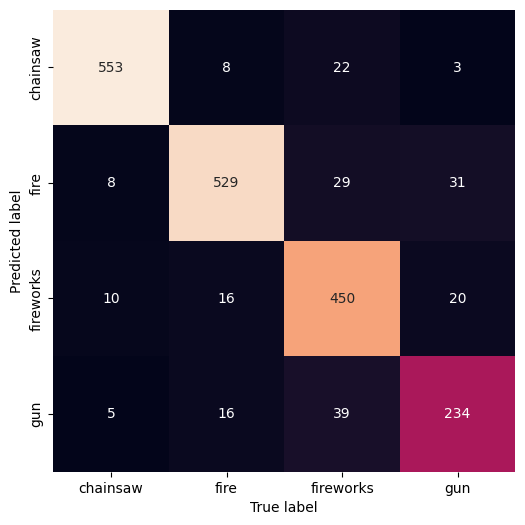

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
import pickle
from sklearn.decomposition import PCA

# [1] Create dataset of feature vectors and split it.
print(f"Number of labels: {y_aug.shape}")


# X_aug = np.load(fm_dir + "feature_matrix_2D_aug.npy")
# y_aug = np.load(fm_dir + "labels_2D_aug.npy", allow_pickle=True)

# X_aug = X_aug / np.linalg.norm(X_aug, axis=1, keepdims=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_aug, y_aug, test_size=0.3, stratify=y_aug
)  # random_state=1
pca = PCA(n_components=16, whiten=True)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
# X_train -= np.mean(X_train, axis=0)
# X_test -= np.mean(X_test, axis=0)
# [2] (optional) Data normalization


filename_pca = "pca_16_rf_components.pickle"
pickle.dump(pca, open(model_dir + filename_pca, "wb"))
# Apply PCA with 10 components





# [3] Model training and selection using Random Forest
best_rf = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    min_impurity_decrease=0.0,
    random_state=42,
    max_features="sqrt",
    
)

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
accuracies_rf = np.zeros((n_splits,))

for k, idx in enumerate(kf.split(X_train, y_train)):
    print(f"Fold {k + 1}/{n_splits}")
    idx_learn, idx_val = idx
    best_rf.fit(X_train[idx_learn], y_train[idx_learn])
    prediction_rf = best_rf.predict(X_train[idx_val])
    accuracies_rf[k] = balanced_accuracy_score(y_train[idx_val], prediction_rf)

# [4] Save the trained model
filename_model = "best_rf_model.pickle"
pickle.dump(best_rf, open(model_dir + filename_model, "wb"))

# [5] Evaluate the model
print(f"Mean accuracy with Random Forest 5-Fold CV: {100 * accuracies_rf.mean():.1f}%")
print(f"Std deviation in accuracy with 5-Fold CV: {100 * accuracies_rf.std():.1f}%")
from sklearn.metrics import balanced_accuracy_score
y_pred = best_rf.predict(X_test)
accuracy_rf = balanced_accuracy_score(y_test, y_pred)
print(f"Test set accuracy with Random Forest: {accuracy_rf * 100:.2f}%")

# Show the confusion matrix
show_confusion_matrix(y_pred, y_test, classnames)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

# Initialize lists to store balanced accuracy scores
original_scores = []
augmented_scores = []

# Perform the evaluation 10 times
for _ in range(10):
    # Split the original dataset
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
        X, y, test_size=0.3, random_state=None, stratify=y
    )

    # Split the augmented dataset
    X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
        X_aug, y_aug, test_size=0.3, random_state=None, stratify=y_aug
    )

    # Define the Random Forest model
    rf_model = RandomForestClassifier(
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=200,
        min_impurity_decrease=0.0,
        random_state=42,
        max_features="sqrt",
    )

    # Train and evaluate on the original dataset
    rf_model.fit(X_train_orig, y_train_orig)
    y_pred_orig = rf_model.predict(X_test_orig)
    accuracy_orig = balanced_accuracy_score(y_test_orig, y_pred_orig)
    original_scores.append(accuracy_orig)

    # Train and evaluate on the augmented dataset
    rf_model.fit(X_train_aug, y_train_aug)
    y_pred_aug = rf_model.predict(X_test_aug)
    accuracy_aug = balanced_accuracy_score(y_test_aug, y_pred_aug)
    augmented_scores.append(accuracy_aug)

# Create a box plot to compare the results
plt.figure(figsize=(10, 6))
plt.boxplot([original_scores, augmented_scores], labels=["Original Dataset", "Augmented Dataset"])
plt.title("Comparison of Balanced Accuracy Scores for Random Forest Model")
plt.ylabel("Balanced Accuracy Score")
plt.grid(True)

# Save the plot as a PDF
pdf_filename = "rf_balanced_accuracy_comparison.pdf"
with PdfPages(pdf_filename) as pdf:
    pdf.savefig()  # Save the current figure
    plt.close()

# Print the results
print(f"Original Dataset: Mean = {np.mean(original_scores):.4f}, Std = {np.std(original_scores):.4f}")
print(f"Augmented Dataset: Mean = {np.mean(augmented_scores):.4f}, Std = {np.std(augmented_scores):.4f}")
print(f"Box plot saved as {pdf_filename}")

Original Dataset: Mean = 0.7689, Std = 0.0491
Augmented Dataset: Mean = 0.8504, Std = 0.0089
Box plot saved as rf_balanced_accuracy_comparison.pdf


/tmp/ipykernel_105092/2743479153.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([original_scores, augmented_scores], labels=["Original Dataset", "Augmented Dataset"])
